# Understanding aperture photometry & making custom apertures. 

## Learning goals

In our previous tutorials ([LightCurve Object](LightCurve-object-Tutorial.html) and [LightCurveFile Objects](LightCurveFile-Object-Tutorial.html)) we learned about aperture photometry and the Simple Aperture Photometry (SAP)and Pre-search Data Conditioning SAP (PDCSAP) flux.

We have not however discussed how these apertures are chosen by the pipeline or how to examine them. 

In this proposal we will cover the following, 
- How apertures are defined.
- How can we examine a pre-defined aperture.
- How we can define and modify an aperture and recover the light curve.

## SPOC Apertures

In aperture photometry A set of pixels in the image are chosen and we sum those to produce a single flux value. 
The [SPOC](https://heasarc.gsfc.nasa.gov/docs/tess/pipeline.html) produces an *optimal aperture*, which is used by default in *Lightkurve*, and determined by the [data processing pipeline](https://github.com/nasa/kepler-pipeline). This is the default aperture used by *Lightkurve* and is optimized to ensure that the stellar signal has a high signal to noise ratio, with minimal contamination from the background.

We sum these same pre-selected pixels for every image at each cadence to produce a light curve.

There are however, some cases where you might want to produce your own aperture. The field may be crowded, or you may wish to change the aperture size to change the relative contribution of the background. *Lightkurve* offers tools to select pixels programmatically.

We will show you how to examine the pre-selected aperture and how to modify it if you wish.

## Imports
This tutorial requires:
- **[Lightkurve](https://docs.lightkurve.org)** 
- [**Matplotlib**](https://matplotlib.org/) 
- [**numpy**](https://numpy.org)

## Defining terms

- Target Pixel File (TPF): A file containing the original CCD pixel observations from which light curves are extracted. 

- LightCurve Object: Obtained from a TPF and contains light curve information derived using simple aperture photometry.

- LightCurveFile Object: Obtained from MAST and contains both SAP flux and PSDCSAP flux.

- Cadence: The rate at which TESS photometric observations are stored. 

- Sector: One of TESS's 27 (to date) observing periods, approximately ~27 days in duration.

- Simple Aperture Photometry (SAP):  The act of summing all pixel values in a pre-defined aperture as a function of time.

-  Pre-search Data Conditioning SAP flux (PDCSAP) flux : SAP flux from which long term trends have been removed using so-called Co-trending Basis Vectors (CBVs). PDCSAP flux is usually cleaner data than the SAP flux and will have fewer systematic trends.

In [1]:
%matplotlib inline 
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt

## Downloading the data
For this tutorial lets use the [L 98-59 System](https://arxiv.org/pdf/1903.08017.pdf) again, focusing on  planet c. First let's search for a TPF for this object.

In [2]:
search_result = lk.search_targetpixelfile('TIC 307210830')
search_result

SearchResult containing 7 data products.

 #   observation   author target_name                     productFilename                     distance
--- -------------- ------ ----------- ------------------------------------------------------- --------
  0  TESS Sector 2   SPOC   307210830 tess2018234235059-s0002-0000000307210830-0121-s_tp.fits      0.0
  1  TESS Sector 5   SPOC   307210830 tess2018319095959-s0005-0000000307210830-0125-s_tp.fits      0.0
  2  TESS Sector 8   SPOC   307210830 tess2019032160000-s0008-0000000307210830-0136-s_tp.fits      0.0
  3  TESS Sector 9   SPOC   307210830 tess2019058134432-s0009-0000000307210830-0139-s_tp.fits      0.0
  4 TESS Sector 10   SPOC   307210830 tess2019085135100-s0010-0000000307210830-0140-s_tp.fits      0.0
  5 TESS Sector 11   SPOC   307210830 tess2019112060037-s0011-0000000307210830-0143-s_tp.fits      0.0
  6 TESS Sector 12   SPOC   307210830 tess2019140104343-s0012-0000000307210830-0144-s_tp.fits      0.0

Lets pick and download the data for sector 2.

In [3]:
tpf_file = search_result[0].download()
tpf_file

TessTargetPixelFile(TICID: 307210830)

We now have a TPF file for our object in sector 2. The optimal aperture is stored in the TPF as the `pipeline_mask` property. We can have a look at it by calling it here:

In [4]:
tpf_file.pipeline_mask

array([[False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True, False, False,
        False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False],
       [False, False, False, False,  True,  True,  True,  True, False,
        False, False],
       [False, False, False, False, False,  True,  True, False, False,
        False, False],
       [False, False, False, False, False, False, False, False, False,
        False, False],
       [False, False, False, False, False, False, False, Fal

As you can see, it is a boolean array detailing which pixels are included. We can plot this aperture over the top of our TPF using the `plot()` function, and passing in the mask to the `aperture_mask` keyword.

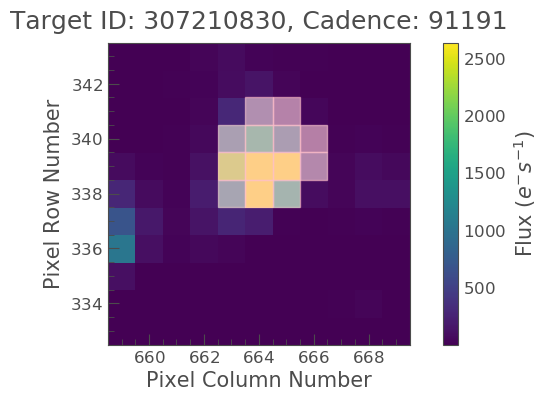

In [5]:
tpf_file.plot(aperture_mask=tpf_file.pipeline_mask);

We now see the SPOC *optimal* aperture mask overlaid on top of our object of interest.

Using the provided optimal aperture in `pipeline_mask` and the TPF we can perform simple aperture photometry via the [`extract_aperture_photometry()`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.TessTargetPixelFile.html#lightkurve.targetpixelfile.TessTargetPixelFile.extract_aperture_photometry) function as shown below,

In [6]:
lc = tpf_file.extract_aperture_photometry()
lc

<TessLightCurve targetid=307210830 length=18317>
       time              flux           flux_err      ... cadenceno quality
                     electron / s     electron / s    ...                  
      object           float32          float32       ...   int32    int32 
------------------ --------------- ------------------ ... --------- -------
1354.1088231272427 21566.349609375 16.116119384765625 ...     91191       0
1354.1102119888994  21563.88671875 16.118038177490234 ...     91192       0
 1354.112989712153 21475.162109375 16.089221954345703 ...     91194       0
1354.1143785738097  21583.30859375  16.12527084350586 ...     91195       0
1354.1157674355243    21575.640625 16.121679306030273 ...     91196       0
1354.1171562971804   21563.1015625 16.115528106689453 ...     91197       0
1354.1185451588947 21552.935546875 16.112627029418945 ...     91198       0
1354.1199340205515  21532.90234375  16.10567855834961 ...     91199       0
1354.1213228822667    21533.828125 16.105731964111328 ...     91200       0
               ...             ...                ... ...       ...     ...
1381.5001032523294 21262.494140625 16.291688919067383 ...    110913       0
1381.5014921207378    21289.828125 16.302898406982422 ...    110914       0
1381.5028809891458   21266.3515625  16.29288673400879 ...    110915       0
1381.5042698574382 21234.845703125 16.279603958129883 ...    110916       0
1381.5056587258466    21244.953125 16.281909942626953 ...    110917       0
1381.5070475942555   21210.7578125 16.267162322998047 ...    110918       0
 1381.508436462548  21231.01171875  16.27315330505371 ...    110919       0
1381.5098253309563 21250.466796875 16.277507781982422 ...    110920       0
1381.5112141992488  21236.35546875   16.2720890045166 ...    110921       0
1381.5126030676577  21265.83984375 16.278945922851562 ...    110922       0

The same result can also be obtained via, 
```
lc = tpf_file.to_lightcurve(aperture_mask=tpf_file.pipeline_mask)
```

## Creating your own masks

You don't necessarily have to pass in the `pipeline_mask` to the `plot()` function, it can be any mask you choose yourself, provided it is the right shape. We will now explain how to adjust this mask using the [`create_threshold_mask`](https://docs.lightkurve.org/api/lightkurve.targetpixelfile.TessTargetPixelFile.html?highlight=create_threshold_mask#lightkurve.targetpixelfile.TessTargetPixelFile.create_threshold_mask) function. This method will identify the pixels in the TPF which show a median flux that is brighter than threshold times the standard deviation above the overall median. The standard deviation is estimated in a robust way by multiplying the Median Absolute Deviation (MAD) with 1.4826. In this example we will pick 10 as our threshold.

In [7]:
target_mask = tpf_file.create_threshold_mask(threshold=10, reference_pixel='center')
n_target_pixels = target_mask.sum()
n_target_pixels

13

We have now created a target mask which covers 13 pixels. Lets plot this up and see what it looks like.

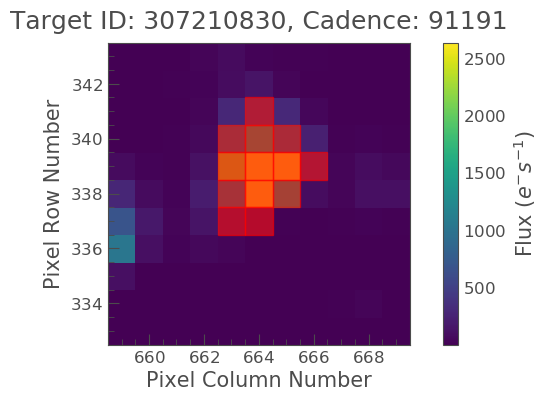

In [8]:
tpf_file.plot(aperture_mask=target_mask, mask_color='r');

We see that this is slightly different to the *optimal* aperture previously defined. It also looks like there might be too many background pixels included. Lets see if we can adjust this. 

### Specify an aperture array
We need to define a new aperture array such that our aperture will cover our object of interest only. We have seen that apertures are defined within boolean arrays, based on this lets make up a new array.

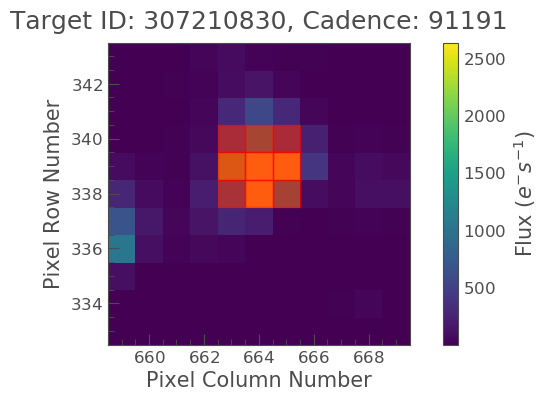

In [9]:
aper_new = np.zeros(tpf_file.shape[1:], dtype=bool)
aper_new[5:8, 4:7] = True
tpf_file.plot(aperture_mask=aper_new, mask_color='red')

OK great, it looks like we have covered our object, but not included too much background. Lets now make this into a light curve.

In [10]:
target_lc_new = tpf_file.to_lightcurve(aperture_mask=aper_new)
target_lc_new

<TessLightCurve targetid=307210830 length=18317>
       time              flux           flux_err      ... cadenceno quality
                     electron / s     electron / s    ...                  
      object           float32          float32       ...   int32    int32 
------------------ --------------- ------------------ ... --------- -------
1354.1088231272427  20049.26953125  15.38568115234375 ...     91191       0
1354.1102119888994   20029.6015625 15.380707740783691 ...     91192       0
 1354.112989712153  19982.47265625 15.365057945251465 ...     91194       0
1354.1143785738097 19994.115234375 15.368595123291016 ...     91195       0
1354.1157674355243 20003.728515625 15.371517181396484 ...     91196       0
1354.1171562971804  19999.60546875 15.368359565734863 ...     91197       0
1354.1185451588947   20019.8046875 15.375614166259766 ...     91198       0
1354.1199340205515 19982.787109375 15.361979484558105 ...     91199       0
1354.1213228822667  20002.78515625 15.369135856628418 ...     91200       0
               ...             ...                ... ...       ...     ...
1381.5001032523294 19974.763671875 15.560335159301758 ...    110913       0
1381.5014921207378 19988.509765625  15.56753158569336 ...    110914       0
1381.5028809891458         19959.5  15.55550765991211 ...    110915       0
1381.5042698574382 19942.931640625 15.547529220581055 ...    110916       0
1381.5056587258466    19961.890625 15.553683280944824 ...    110917       0
1381.5070475942555  19938.53515625 15.542488098144531 ...    110918       0
 1381.508436462548  19942.68359375 15.544118881225586 ...    110919       0
1381.5098253309563 19965.841796875 15.549737930297852 ...    110920       0
1381.5112141992488    19945.671875 15.542808532714844 ...    110921       0
1381.5126030676577    19982.890625  15.55328369140625 ...    110922       0

## Compare data & light curves

We have now created light curve objects using both the SPOC pre-defined aperture and a mask of our own devising. Lets plot these light curves up and examine the difference.

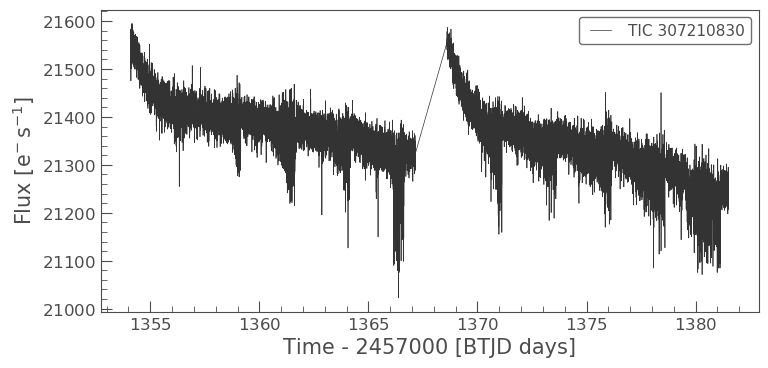

In [11]:
lc.plot();

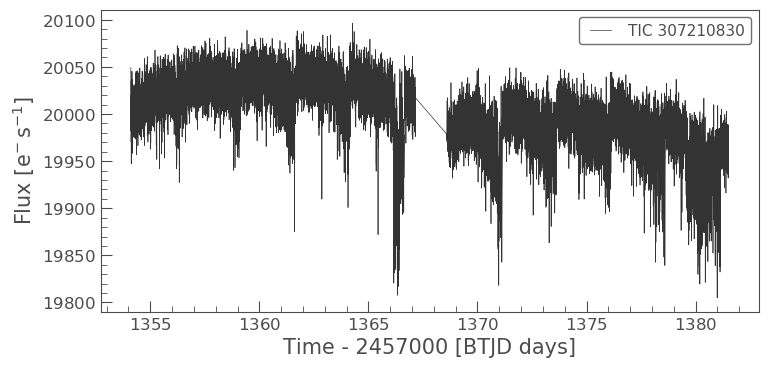

In [12]:
target_lc_new.plot();

As you can see the light curves from the two apertures look very different. It looks as if the aperture we have defined manually may have less background or contaminating flux from scattered than the SPOC aperture. We will learn more about contamination in our [next tutorial](Visual-inspection-Tutorial.html).